In [1]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
seed(1)

In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [6]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [7]:
#get randomized RBM parameters
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [8]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [9]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [10]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [30]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol=1e-04,full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [25]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [26]:
#Parameter definition 
N_values = np.arange(2,6)
M=1
B = 0
A0 = 1
gdResults = []
gdTime = []
edResults = []
edTime = []
engErr = []
stateErr = []

In [ ]:
#vary N value
for i in range(N_values.size):
    #gradient descent
    gradDescent = GradDescent(N_values[i], B, A0)
    gd = gradDescent(N_values[i], M)
    gdResults.append(gd[0])
    gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N_values[i],B,A0)
    ed = groundState()
    edResults.append(ed[0])
    edTime.append(ed[1])
    
    #Error
    gdEng = gd[0][2]
    edEng = ed[0][0]
    gdState = gd[0][1]
    edState = ed[0][1]
    errTemp = err(gdState,edState,gdEng,edEng)
    engErr.append(errTemp[0])
    stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.749997
         Iterations: 32
         Function evaluations: 888
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: -0.999961
         Iterations: 161
         Function evaluations: 5728
         Gradient evaluations: 358
Optimization terminated successfully.
         Current function value: -1.249928
         Iterations: 219
         Function evaluations: 10680
         Gradient evaluations: 534


In [28]:
print('Gradient Descent Time: ', gdTime)
print('Exact Diagonalization Time: ', edTime)
print('Energy Energy: ', engErr)
print('Wavefunction Energy: ', stateErr)



Gradient Descent Time:  [22.091896533966064, 131.61236333847046, 67.7478392124176, 1496.2081820964813]
Exact Diagonalization Time:  [0.000997304916381836, 0.0009975433349609375, 0.000997304916381836, 0.029880046844482422]
Energy Energy:  [1.133290382648866e-07, 4.4486345209815426e-06, nan, 5.9769270520870776e-05]
Wavefunction Energy:  [5.6664520631244386e-08, 0.003245135811114075, nan, 0.963123866242662]


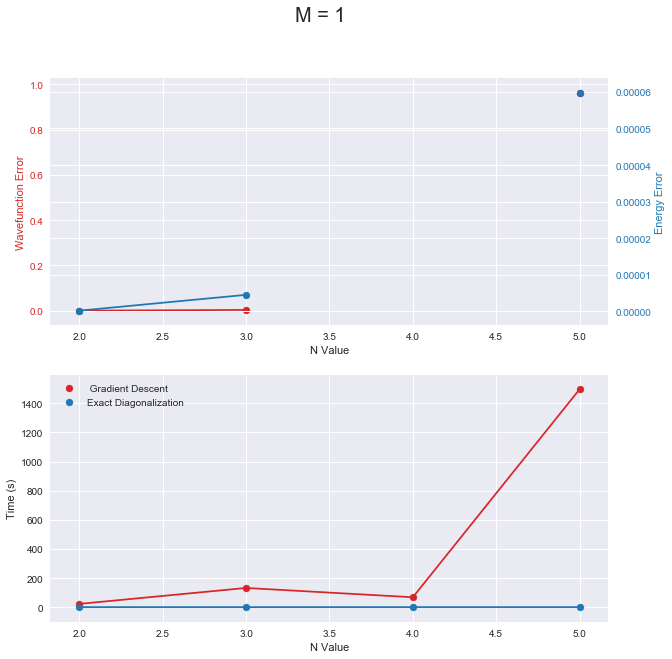

In [29]:
#
plt.figure(figsize=(10,10))
ttl = plt.suptitle("M = 1",size =20)
ax1 = plt.subplot(2,1,1)

color = 'tab:red'
ax1.set_xlabel('N Value')
ax1.set_ylabel('Wavefunction Error', color=color)
ax1.plot(N_values, stateErr,color=color)
ax1.scatter(N_values, stateErr,color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Energy Error', color=color)  
ax2.plot(N_values, engErr, color=color)
ax2.scatter(N_values, engErr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = plt.subplot(2,1,2)

color = 'tab:red'
ax3.set_xlabel('N Value')
ax3.set_ylabel('Time (s)')
ax3.plot(N_values, gdTime,color=color)
ax3.scatter(N_values, gdTime,color=color, label = ' Gradient Descent')
color = 'tab:blue'
ax3.plot(N_values, edTime, color=color)
ax3.scatter(N_values, edTime, color=color, label = 'Exact Diagonalization')
ax3.legend()
plt.show()